# Store Item Demand Forecasting - Data Analysis
This is the first notebook on this project where I'll be running a data analysis process on the product sales dataset available at the Kaggle's *Store Item Demand Forecasting Challende*.

<img src="https://i.ibb.co/FDsQbZX/kaggle-comp-banner.png" width="900" />

**Challenge Description**: <br>

<i>
This competition is provided as a way to explore different time series techniques on a relatively simple and clean dataset.

You are given 5 years of store-item sales data, and asked to predict 3 months of sales for 50 different items at 10 different stores.

What's the best way to deal with seasonality? Should stores be modeled separately, or can you pool them together? Does deep learning work better than ARIMA? Can either beat xgboost?

This is a great competition to explore different models and improve your skills in forecasting.
</i>

**Challenge Goal**: <br>

<i>
The objective of this competition is to predict 3 months of item-level sales data at different store locations. (with no holiday effect)
</i>

**Author**: Arthur G.

## Loading Dependencies
Here I'll be loading and setting up the dependencies for this notebook.

In [1]:
# add custom functions
import sys
sys.path.append('../')

# add libs
import os
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
from fbprophet import Prophet
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error

# setting up libs
warnings.filterwarnings('ignore')
seed = np.random.seed(42)
pd.set_option('display.max_columns', None)
pd.set_option('display.precision', 3)
plt.style.use('ggplot')
plt.rc('font', **{'family': 'DejaVu Sans', 'size': 22})

## Loading Data
Now it's time to load the dataset.

In [2]:
sales_df = pd.read_csv(os.path.join('..', 'data', 'raw', 'train.csv'))

sales_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   date    913000 non-null  object
 1   store   913000 non-null  int64 
 2   item    913000 non-null  int64 
 3   sales   913000 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 27.9+ MB


So we have records for a total of 50 unique products sold across 10 different stores, in 10 different regions of the country, and we have no missing data.

## Analyzing Distributions
Let's do some visual check on the different data distributions, starting by the distribution of sales across the different stores.

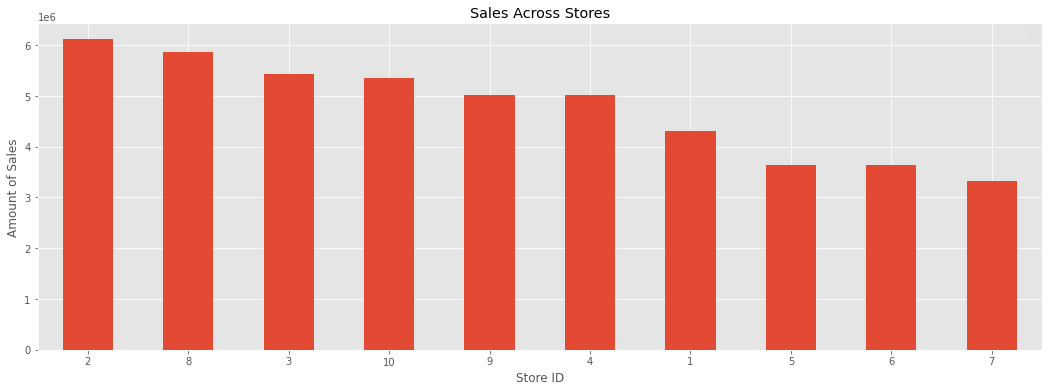

In [3]:
# grouping to plot
sales_df[['store', 'sales']].groupby(['store']).sum().sort_values(by='sales', ascending=False).plot.bar(figsize=(18, 6))

# plot configs
plt.title('Sales Across Stores')
plt.ylabel('Amount of Sales')
plt.xlabel('Store ID')
plt.legend([])
plt.xticks(rotation=0.9)
plt.show()

It seems that the number of sales is pretty balanced across the different stores. Let's now look at the same distribution, but in the product regard.

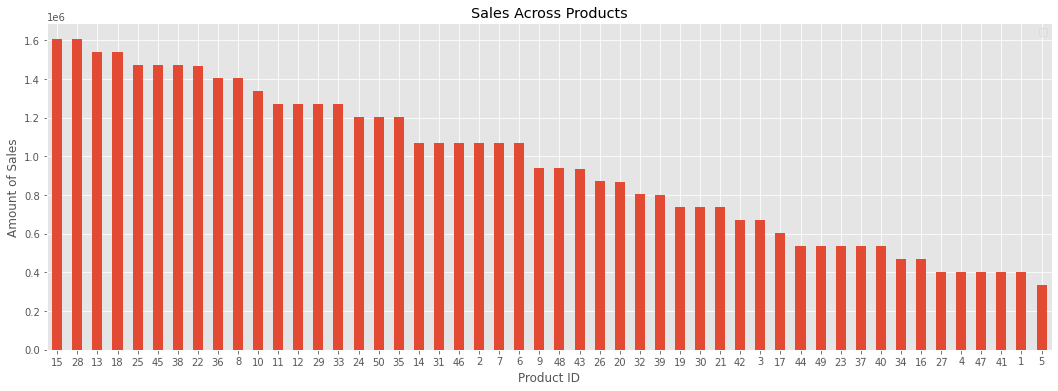

In [4]:
sales_df[['item', 'sales']].groupby(['item']).sum().sort_values(by='sales', ascending=False).plot.bar(figsize=(18, 6))
plt.title('Sales Across Products')
plt.ylabel('Amount of Sales')
plt.xlabel('Product ID')
plt.legend([])
plt.xticks(rotation=0.9)
plt.show()

Nothing to be concerned with here.

## Analyzing One Product
Let's use the combination of the product and store with most sales to try to visually indentify a seasonality.

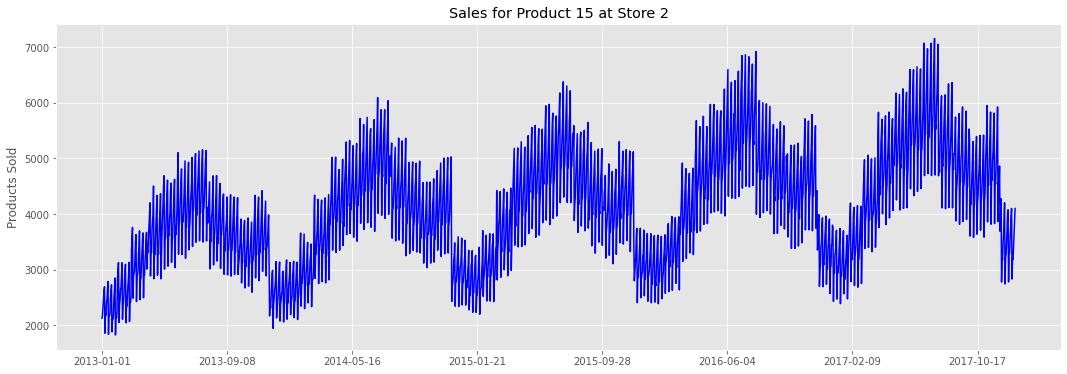

In [5]:
# filtering product_store, using date as index and adjusting frequency
product_store_analysis_hg = sales_df[(sales_df['item'] == 15) | (sales_df['store'] == 2)]
product_store_analysis_hg = product_store_analysis_hg.drop(columns=['store', 'item'])
product_store_analysis_hg = product_store_analysis_hg.groupby(['date']).sum()
product_store_analysis_hg = product_store_analysis_hg

# making the plot
plt.figure()
_ = product_store_analysis_hg.sales.plot(figsize=(18, 6), color='blue')
plt.title('Sales for Product 15 at Store 2')
plt.ylabel('Products Sold')
plt.xlabel('')
plt.show()

We can clearly see a seasonal pattern beautifully defined in the plot. :)

Now let's do the same for the product and store with the lowest sales history.

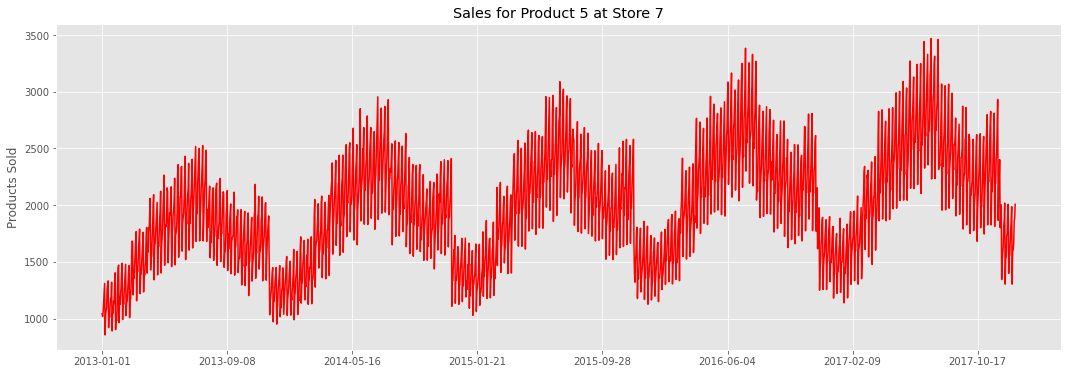

In [6]:
# filtering product_store, using date as index and adjusting frequency
product_store_analysis_lw = sales_df[(sales_df['item'] == 5) | (sales_df['store'] == 7)]
product_store_analysis_lw = product_store_analysis_lw.drop(columns=['store', 'item'])
product_store_analysis_lw = product_store_analysis_lw.groupby(['date']).sum()
product_store_analysis_lw = product_store_analysis_lw

# making the plot
plt.figure()
_ = product_store_analysis_lw.sales.plot(figsize=(18, 6), color='red')
plt.title('Sales for Product 5 at Store 7')
plt.ylabel('Products Sold')
plt.xlabel('')
plt.show()

It's good to see that even the combination of the "worst" product and "worst" store, in terms of number of sales, has more than enogh data to train an algorithm such as the <a href="https://facebook.github.io/prophet/" target="blank">Facebook's Prophet</a> in a reliable way.

## Experimenting With Prophet
Here I'll be using the Prophet time series forecaster to test it's capabilities in the combination of product and store with the least amount of sales.

Let's start by making the data ready for modeling.

In [7]:
# resetting index
product_store_analysis_lw = product_store_analysis_lw.reset_index(drop=False)

# renaming variables to match Prophet's requirements
product_store_analysis_lw.rename(columns={'date': 'ds', 'sales': 'y'}, inplace=True)
product_store_analysis_lw.ds = pd.to_datetime(product_store_analysis_lw.ds)
product_store_analysis_lw.head()

,ds,y
0,2013-01-01,1042
1,2013-01-02,1017
2,2013-01-03,1053
3,2013-01-04,1144
4,2013-01-05,1222


It's time to split the train and test sets.

In [8]:
test_size = 91
train_set = product_store_analysis_lw.iloc[:-test_size, :]
test_set = product_store_analysis_lw.iloc[-test_size:, :]

As we do not have any additional column to use as an external regressor, nor the data has any holiday effect, we're done. Let's build the model.

In [9]:
model = Prophet(
    daily_seasonality=True,
    weekly_seasonality=True,
    yearly_seasonality=True,
    seasonality_mode='multiplicative'
)

model.fit(train_set)

Initial log joint probability = -21.3371
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5448.37    0.00107954       235.612      0.7581      0.7581      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       5454.52     0.0103907       321.942       1.042      0.1042      237   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       5457.25    0.00442954       206.389           1           1      360   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       5459.91    0.00011865       411.637       0.122       0.122      488   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       5461.98   0.000739099       104.065      0.9118      0.9118      613   
    Iter      log prob        ||dx||      ||grad||       alpha  

9       5472.73   0.000303332       202.696           1           1     1377   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1199       5473.05   0.000392556       397.139     0.01889           1     1502   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1231       5473.19   5.55749e-06       170.206   5.033e-08       0.001     1596  LS failed, Hessian reset 
    1299       5473.33   7.81158e-05       363.178      0.5597      0.5597     1689   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1399       5473.45   2.38946e-05        161.64      0.4566      0.4566     1815   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1424       5473.51   2.53706e-06        87.871   1.415e-08       0.001     1892  LS failed, Hessian reset 
    1499       5473.64   0.000346471       154.705      0.1275       

Now let's make the future predictions corresponding to sales in the test set.

In [11]:
# forecasting
future = model.make_future_dataframe(periods=len(test_set), freq='D')
forecast = model.predict(future)

# getting test predictions
forecast_test = forecast.yhat[-test_size:]
forecast_test.index = test_set.ds

forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,daily,daily_lower,daily_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
0,2013-01-01,502.122,893.828,1119.152,502.122,502.122,2.147,2.147,2.147,1.015,1.015,1.015,-0.239,-0.239,-0.239,-0.892,-0.892,-0.892,0.0,0.0,0.0,1011.826
1,2013-01-02,502.275,900.237,1126.677,502.275,502.275,2.147,2.147,2.147,1.020,1.020,1.020,-0.230,-0.230,-0.230,-0.896,-0.896,-0.896,0.0,0.0,0.0,1014.827
2,2013-01-03,502.429,1004.248,1229.027,502.429,502.429,2.147,2.147,2.147,1.215,1.215,1.215,-0.031,-0.031,-0.031,-0.901,-0.901,-0.901,0.0,0.0,0.0,1112.932
3,2013-01-04,502.582,1092.525,1327.002,502.582,502.582,2.147,2.147,2.147,1.411,1.411,1.411,0.170,0.170,0.170,-0.906,-0.906,-0.906,0.0,0.0,0.0,1211.531
4,2013-01-05,502.735,1207.976,1431.054,502.735,502.735,2.147,2.147,2.147,1.622,1.622,1.622,0.387,0.387,0.387,-0.911,-0.911,-0.911,0.0,0.0,0.0,1318.246


Let's plot the generated predictions agains the real data.

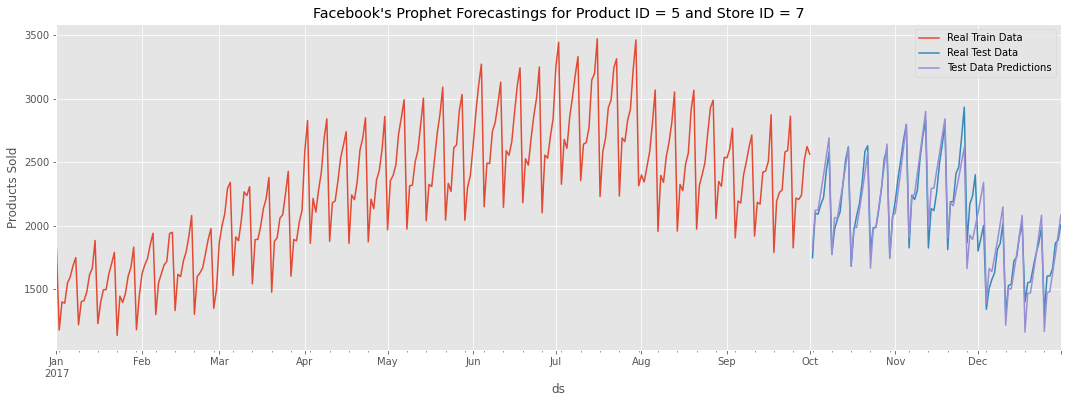

In [18]:
# adjusting index
train_set.index = train_set.ds
test_set.index = test_set.ds

# making plot
plt.figure()
train_set['2017-01-01':].y.plot(legend=True, figsize=(18, 6))
test_set.y.plot(legend=True)
forecast_test.plot(legend=True)
plt.legend(['Real Train Data', 'Real Test Data', 'Test Data Predictions'])
plt.title('Facebook\'s Prophet Forecastings for Product ID = 5 and Store ID = 7')
plt.ylabel('Products Sold')
plt.show()

Now I know we can train several Prophet models at scale in order to cover all product_store combinations. I'll do this on the next notebook.

### Model's Performance Indicators
Let's assess our model performance.

In [24]:
model_performance_indicators(test_set.y.values, forecast_test.values)

MAE: 94.371 | RMSE: 127.492 | MAPE: 4.7 | SMAPE: 4.7


In [26]:
print(f"Median sales: {round(test_set.y.mean(), 3)}")

Median sales: 2077.429


If we take into account the median number of sales on the test set, we've finished this first modeling with a good RMSE and a difference of 4.7% between the real data and what the model predicted.